In [7]:
import os
os.environ['OMP_NUM_THREADS']='1'

import numpy as np
import networkx as nx 

import matplotlib.pyplot as plt

from pyttn import ntree, ntreeNode, ntreeBuilder

from scipy.cluster.hierarchy import linkage

import abc
from math import ceil

In [8]:
def gen_graph(M):
   return nx.from_numpy_array(np.abs(M - np.diag(np.diag(M))))


def chunks(nodes, n):
   N = ceil(len(nodes)/n)
   for i in range(0, len(nodes), N):
      yield nodes[i:i + N]

def __split_node(T, node, children, max_degree, nindex):
   if max_degree > 1:
      if len(children) > max_degree:
         #if the children list is longer than the maximum degree, iterate over creating up to max degree chunks
         for chunk in chunks(children, max_degree):
            print(chunk)
            #for each chunk
            nlabel = nindex
            T.add_edge(node, nlabel)
            nindex += 1
            T, nindex = __split_node(T, nlabel, chunk, max_degree, nindex)
      else:
         for child in children:
            T.add_edge(node, child)
   elif max_degree == 1:
      for child in children:
         T.add_edge(node, child)
         T.add_edge(node, nindex)
         node = nindex
         nindex += 1
   return T, nindex



def split_high_degree_nodes(spanning_tree, N, root_index, max_degree=None):
   if max_degree is None:
      #if max degree has not been specified we just return the current tree
      return spanning_tree
   else:
      #in this case iterate through the tree determine if any nodes are too large and if they are we partition 
      #the node into sets of the correct size.  To do this we get a DFS edges list and if there are any instances
      #of nodes with more than max_degree children we insert sufficiently many logical nodes so that we have the
      #correct degree of connectivity
      edges = sorted([edge for edge in nx.dfs_edges(spanning_tree, source=root_index)], key = lambda x:np.abs(x[0]-root_index))
      print(edges)
      
      nchildren = {}
      nodes_to_split = {}

      curr_node = None
      sind = 0

      #iterate over the edges getting the number of children associated with each node and the location of the
      #first edge associated with a nodes children in the list
      for i, e in enumerate(edges):
         if curr_node != e[0]:
            curr_node = e[0]
            sind = i

         if e[0] not in nchildren.keys():
            nchildren[e[0]]=1
         else:
            nchildren[e[0]]+=1

         if nchildren[e[0]] > max_degree:
            if e[0] not in nodes_to_split.keys():
               nodes_to_split[e[0]]=sind
               
      #if none of the nodes are high degree we don't need to do anything
      if len(nodes_to_split) == 0:
         return spanning_tree
      
      #otherwise we iterate through the tree and split high degree nodes off
      else:
         #now we split any nodes that need to be split
         counter = N
         T = nx.Graph()
         #if we are at a node we need to split
         for node, ind in nodes_to_split.items():
            nchild = nchildren[node]

            #get a list containing all of its children
            children = [ edges[ind+i][1] for i in range(nchild)]

            #and break this into chunks 
            T, counter = __split_node(T, node, children, max_degree, counter)

         for e in edges:
            if e[0] not in nodes_to_split.keys():
               T.add_edge(e[0], e[1])
         return T

def insert_physical_nodes(spanning_tree, N, root_ind):
   nindex = spanning_tree.number_of_nodes()

   mapping = {}
   for i in range(nindex):
      mapping[i] = N+i

   #iterate over the tree and add nodes to any n
   nx.relabel_nodes(spanning_tree, mapping=mapping, copy=False)

   for i in range(N):
      spanning_tree.add_edge(N+i, i)

   return spanning_tree, N+root_ind

def generate_spanning_tree(M, max_degree=None, root_index=0):
   if root_index > M.shape[0] or root_index < 0:
      raise RuntimeError("Failed to generate spanning tree from weight matrix.  User specified root index out of bounds.")
   G = gen_graph(M)

   spanning_tree = nx.maximum_spanning_tree(G)
   spanning_tree = split_high_degree_nodes(spanning_tree, M.shape[0], root_index, max_degree=max_degree)

   return insert_physical_nodes(spanning_tree, M.shape[0], root_index)

def condense_distance_matrix(M):
   N = M.shape[0]

   dist = np.zeros((N*(N-1))//2)
   c = 0
   for i in range(N):
      for j in range(i+1, N):
         dist[c] = M[i, j]
         c += 1
   return dist

def linkage_to_nxtree(Z):
   N = Z.shape[0]+1

   edges = []
   root_index = 0
   #now iterate over links and construct an edge list
   for i in range(Z.shape[0]):
      Z0 = int(Z[i, 0])
      Z1 = int(Z[i, 1])
      edges.append((i+N, Z0))
      edges.append((i+N, Z1))
      root_index = i+N

   T = nx.Graph()
   for e in edges:
      T.add_edge(e[1], e[0])
      T.add_edge(e[0], e[1])

   return T, root_index

def generate_hierarchical_clustering_tree(M):
   dist = condense_distance_matrix(M)
   Z = linkage(dist, method='ward')
   return linkage_to_nxtree(Z,)


def generate_tree_from_matrix(M, method, *args, **kwargs):
   """A function for generating a networkx graph representing a generic tree structure from a
   a matrix describing correlations between nodes.  This function provides several different
   implementations dependent on the choice of 
   :param M: _description_
   :type M: _type_
   :param method: _description_
   :type method: _type_
   """
   return

def convert_nx_to_subtree(spanning_tree, root, root_ind=0):
   root_skip = root.size()
   node_dict = {root_ind: [root_skip]}
   edge_counter = {}

   node_inserted = False  
   for edge in nx.dfs_edges(spanning_tree, source=root_ind):
      #if this is the first edge in the dfs list then we need to insert both nodes
      #so first insert left most node
      if not node_inserted:
         root.at([]).insert(edge[0])
         node_inserted = True

      if edge[0] not in edge_counter.keys():
         edge_counter[edge[0]] = 0
      else:
         edge_counter[edge[0]] += 1

      node_dict[edge[1]] = node_dict[edge[0]] + [edge_counter[edge[0]]]
      root.at(node_dict[edge[0]]).insert(edge[1])

   return [root.at(leaf_inds).value for leaf_inds in root.leaf_indices()]

def convert_nx_to_tree(spanning_tree, root_ind=0):
   tree = ntree(str(spanning_tree.number_of_nodes()))

   node_dict = {root_ind: []}
   edge_counter = {}

   for edge in nx.dfs_edges(spanning_tree, source=root_ind):

      if edge[0] not in edge_counter.keys():
         edge_counter[edge[0]] = 0
      else:
         edge_counter[edge[0]] += 1

      node_dict[edge[1]] = node_dict[edge[0]] + [edge_counter[edge[0]]]
      tree().at(node_dict[edge[0]]).insert(edge[1])

   return tree, [leaf.value for leaf in tree.leaves()]


[(0, 5), (0, 1), (0, 2), (0, 3), (0, 4), (5, 10), (5, 6), (5, 7), (5, 8), (5, 9), (10, 15), (10, 11), (10, 12), (10, 13), (10, 14), (15, 20), (15, 16), (15, 17), (15, 18), (15, 19), (20, 25), (20, 21), (20, 22), (20, 23), (20, 24), (25, 30), (25, 26), (25, 27), (25, 28), (25, 29), (30, 35), (30, 31), (30, 32), (30, 33), (30, 34), (35, 36), (35, 37), (35, 38), (35, 39)]
[84, 4, 3, 2, 1, 89, 9, 8, 7, 6, 94, 14, 13, 12, 11, 99, 19, 18, 17, 16, 104, 24, 23, 22, 21, 109, 29, 28, 27, 26, 114, 34, 33, 32, 31, 118, 39, 38, 37, 36, 35, 30, 25, 20, 15, 10, 5, 0]


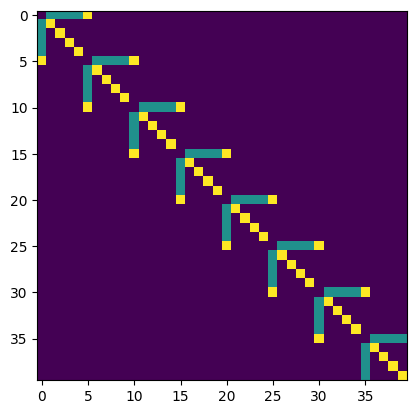

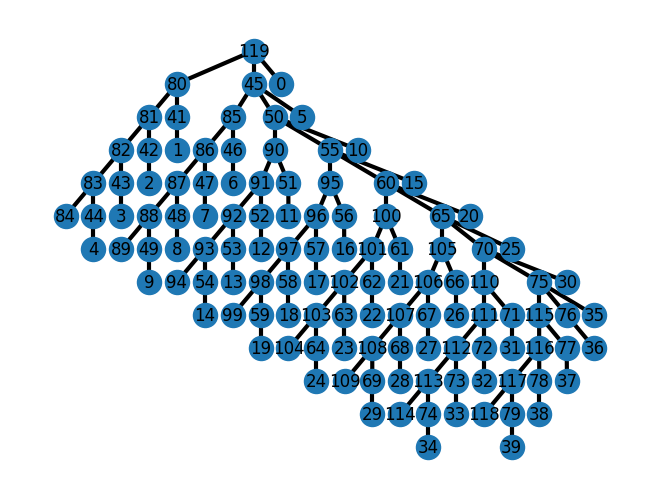

In [9]:
from pyttn.utils import visualise_tree


tree = ntree("(0(121))")
tree2 = ntree("(0(121))")

N=4
M=8
#G = nx.erdos_renyi_graph(N, 0.1)
#gamma = nx.to_numpy_array(G)
v = 0.5*np.ones(N)#np.random.uniform(0, 1, size=N)
w = np.diag(np.ones(N))#np.random.uniform(0, 1, size=(N)))
w = (w + w.T)/2.0
gamma = np.zeros((N+1, N+1))
gamma[0, 1:] = v
gamma[1:, 0] = v
gamma[1:, 1:] = w
gamma += 1e-15

G2 = np.zeros((M*(N+1),M*(N+1)))
for i in range(M):
   G2[i*(N+1):(i+1)*(N+1), i*(N+1):(i+1)*(N+1)]=gamma

for i in range(M-1):
   G2[i*(N+1), (i+1)*(N+1)] = 1
   G2[(i+1)*(N+1), i*(N+1)] = 1


plt.figure(1)
plt.imshow(G2)

spanning_tree, spanning_root_ind = generate_spanning_tree(G2, max_degree=1, root_index=0)

tree, leaf_ordering = convert_nx_to_tree(spanning_tree, root_ind=spanning_root_ind)
print(leaf_ordering)

plt.figure(2)
visualise_tree(tree, prog='dot')
